In [1]:
from functions import *

In [2]:
hidden_width = 32
hidden_nblocks = 4
train_max_epoch = 10
max_iterations = 1

chip_size = 16
data_root = "geomorph_data_shap"
# data_root = "geomorph_data_test"
n_channels = len(os.listdir(data_root))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
L2_param = 1e-5

label_name = "visible_ice"
num_classes = 5
output_size = num_classes

sm = nn.Softmax(dim=-1)

In [3]:
print(n_channels)

6


In [4]:
feature_names = [None] * n_channels
for i, file in enumerate(os.listdir(data_root)):
    feature_names[i] = file

In [5]:
from pathlib import Path
models_dir = 'resnet_shap_models/'
Path(models_dir).mkdir(parents=True, exist_ok=True)

In [6]:
df = pd.read_csv('data_stephen_fix_header.csv', header=[0])
scaler = preprocess_df(df)
    
print(df.shape[0])
print(df['borehole'].nunique())
df.head()

2837
566


,latitude,longitude,time,borehole,depth,frozen,cryostructures,visible_ice,ASTM_2488,materials,...,top_of_interval,bottom_of_interval,month,year,month_cyclic,lat_norm,lng_norm,depth_norm,year_norm,month_cyclic_norm
0,69.16162,-133.08682,2012-03-21T00:00:00Z,0170-1-10,0.15,0,NaN,NaN,TOPSOIL,Organics,...,0.0,0.3,3,2012,3,1.439946,1.851455,-1.024190,-1.164992,-1.225295
1,69.16162,-133.08682,2012-03-21T00:00:00Z,0170-1-10,0.85,1,NaN,Pure ice,ICE,Ice,...,0.3,1.4,3,2012,3,1.439946,1.851455,-0.835900,-1.164992,-1.225295
2,69.16162,-133.08682,2012-03-21T00:00:00Z,0170-1-10,1.90,1,Nf,No visible ice,SW-SM,Coarse till,...,1.4,2.4,3,2012,3,1.439946,1.851455,-0.553466,-1.164992,-1.225295
3,69.16162,-133.08682,2012-03-21T00:00:00Z,0170-1-10,5.40,1,Nf,No visible ice,GW-GM,Coarse till,...,2.4,8.4,3,2012,3,1.439946,1.851455,0.387982,-1.164992,-1.225295
4,69.16105,-133.08880,2012-03-21T00:00:00Z,0170-1-12,1.20,1,Nf,No visible ice,GP-GM,Coarse till,...,0.0,2.4,3,2012,3,1.437795,1.842620,-0.741756,-1.164992,-1.225295


## Filter depth layer

In [7]:
layer_top = 0
layer_bottom = 30

df = df.loc[(df['depth'] >= layer_top) & (df['depth'] < layer_bottom)]

In [8]:
df = filter_df_visible_ice(df)

In [9]:
df['visible_ice_code'] =  df['visible_ice'].cat.codes

In [10]:
len(df)

2752

In [11]:
base_lat = 70
base_lng = -135

loaded_dataset = Geo90Dataset(data_root, df, base_lat, base_lng, chip_size)

(6000, 6000)
(6000, 6000)
(6000, 6000)
(6000, 6000)
(6000, 6000)
(6000, 6000)
Dataset initialized


In [12]:
valid_ind = []
for i, data in enumerate(loaded_dataset):
    image = data['image']
    ind  = (image == -9999)
    if ~torch.any(ind):
        valid_ind.append(i)

full_dataset = torch.utils.data.Subset(loaded_dataset, valid_ind)


print(len(loaded_dataset))
print(len(full_dataset))

2752
2725


In [13]:
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# batchsize can cause error when last leftover batchsize is 1, batchnorm cannot function on 1 sample data
batchsize = 20
while(train_size % batchsize == 1):
    batchsize+=1
print(batchsize)

train_data, test_data = torch.utils.data.random_split(full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

trainloader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
testloader = DataLoader(test_data, batch_size=batchsize, shuffle=True)

20


In [14]:
def train_resnet(trainloader, testloader, print_epochs = False, loss_fn = torch.nn.CrossEntropyLoss(), n_channels = 1):
    
    model= models.resnet18()
    model.conv1 = nn.Conv2d(n_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.fc = nn.Linear(in_features=512, out_features=num_classes)
    
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), weight_decay = L2_param)

    epoch_loss = np.zeros([train_max_epoch, 2])
    for epoch in range(train_max_epoch):  # loop over the dataset multiple times

        model.train()
        running_loss_sum = 0.0
        for i, data in enumerate(trainloader, 0): # loop over each sample
            # get the inputs; data is a list of [inputs, labels]
            image, labels = data['image'].to(device), data[label_name].to(device)

            predicted = model(image)
            
            
#             print(predicted.squeeze().get_device())
#             print('\n')
#             print(labels.get_device())
            
            
            # squeeze: return tensor with all dimensions of size 1 removed
            loss = loss_fn(predicted.squeeze(), labels)
            
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            running_loss_sum += loss.item()

        # ----------- get validation loss for current epoch --------------
        model.eval()
        validation_loss_sum = 0.0
        for i, data in enumerate(testloader, 0): # loop over each sample

            image, labels = data['image'].to(device), data[label_name].to(device)

            predicted = model(image)
            
            loss = loss_fn(predicted.squeeze(), labels)

            validation_loss_sum += loss.item()

        # ---------------- print statistics ------------------------

        running_loss = running_loss_sum / len(trainloader)
        validation_loss = validation_loss_sum / len(testloader)
        epoch_loss[epoch, :] =  [running_loss, validation_loss]
        
        if print_epochs:
            print('epoch %2d: running loss: %.5f, validation loss: %.5f' %
                          (epoch + 1, running_loss, validation_loss))
        
        torch.save(model.state_dict(), os.path.join(models_dir, 'epoch-{}.pt'.format(epoch+1)))
    
    if print_epochs:
        print('Finished Training')
        
    return epoch_loss
        
def test_resnet(epoch_loss, print_model_epoch = False, n_channels = 1):
    
    # ------ select model ---------
    ind = np.argmin(epoch_loss[:, 1])
    
    model= models.resnet18()
    model.conv1 = nn.Conv2d(n_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.fc = nn.Linear(in_features=512, out_features=num_classes)
    
    model.load_state_dict(torch.load('{}epoch-{}.pt'.format(models_dir, ind+1)))
    
    model.to(device)
    
    if print_model_epoch:
        print("epoch {} model selected".format(ind+1))
    
    # evaluate model on test set
    model.eval()

    with torch.no_grad():
        y_pred = []
        y_test = []
        
        
        for i, data in enumerate(testloader, 0):
            image, labels = data['image'].to(device), data[label_name].to(device)
            # y_test.append(label.numpy().list())
            # print(label.shape)
            # print(images.shape)
            output = model(image)
            
            max_results = torch.max(output, dim= -1)
            predicted = max_results.indices
            #predicted = torch.round(output)
            # print(predicted.shape)
            
            y_test.extend(labels.tolist())
            y_pred.extend(predicted.tolist())
            
        arr_accuracy = accuracy_score(y_test, y_pred)
        scores = precision_recall_fscore_support(y_test, y_pred, average=None, zero_division=0)
    return arr_accuracy, scores, model


In [15]:
start = time.time()

epoch_loss = train_resnet(trainloader,testloader, print_epochs = True, n_channels=n_channels)

end = time.time()

print('iteration {} elapsed time: {}'.format(0+1, end-start))

c:\users\mouju\appdata\local\programs\python\python38\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch  1: running loss: 1.53240, validation loss: 1.39953
epoch  2: running loss: 1.43828, validation loss: 1.39231
epoch  3: running loss: 1.43420, validation loss: 1.41676
epoch  4: running loss: 1.40978, validation loss: 1.46761
epoch  5: running loss: 1.40504, validation loss: 1.37874
epoch  6: running loss: 1.42308, validation loss: 1.53423
epoch  7: running loss: 1.40164, validation loss: 1.59409
epoch  8: running loss: 1.37727, validation loss: 1.90323
epoch  9: running loss: 1.38185, validation loss: 1.49198
epoch 10: running loss: 1.38400, validation loss: 1.44614
Finished Training
iteration 1 elapsed time: 41.11111831665039


In [16]:
arr_accuracy, scores, model= test_resnet(epoch_loss, print_model_epoch = True, n_channels=n_channels)

epoch 5 model selected


In [17]:
arr_accuracy

0.3522935779816514

In [ ]:
batch = next(iter(testloader))
batch['image'].shape

test_surfaces = batch['surface_data'].to('cpu')
test_images = batch['image'].to('cpu')

In [20]:
batch = next(iter(trainloader))
train_surfaces = batch['surface_data'].to('cpu')
train_images = batch['image'].to('cpu')

In [21]:
model.to('cpu')

ResNet(
  (conv1): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
import shap
explainer_gen = shap.DeepExplainer(model, train_images)

In [23]:
test_images.shape

torch.Size([20, 6, 16, 16])

In [24]:
# test_images_fewer = test_images[0:10]
# test_images_fewer.shape

torch.Size([10, 6, 16, 16])

In [25]:
shap_values = explainer_gen.shap_values(test_images)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [26]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

In [27]:
test_numpy.shape

(20, 16, 16, 6)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` exp

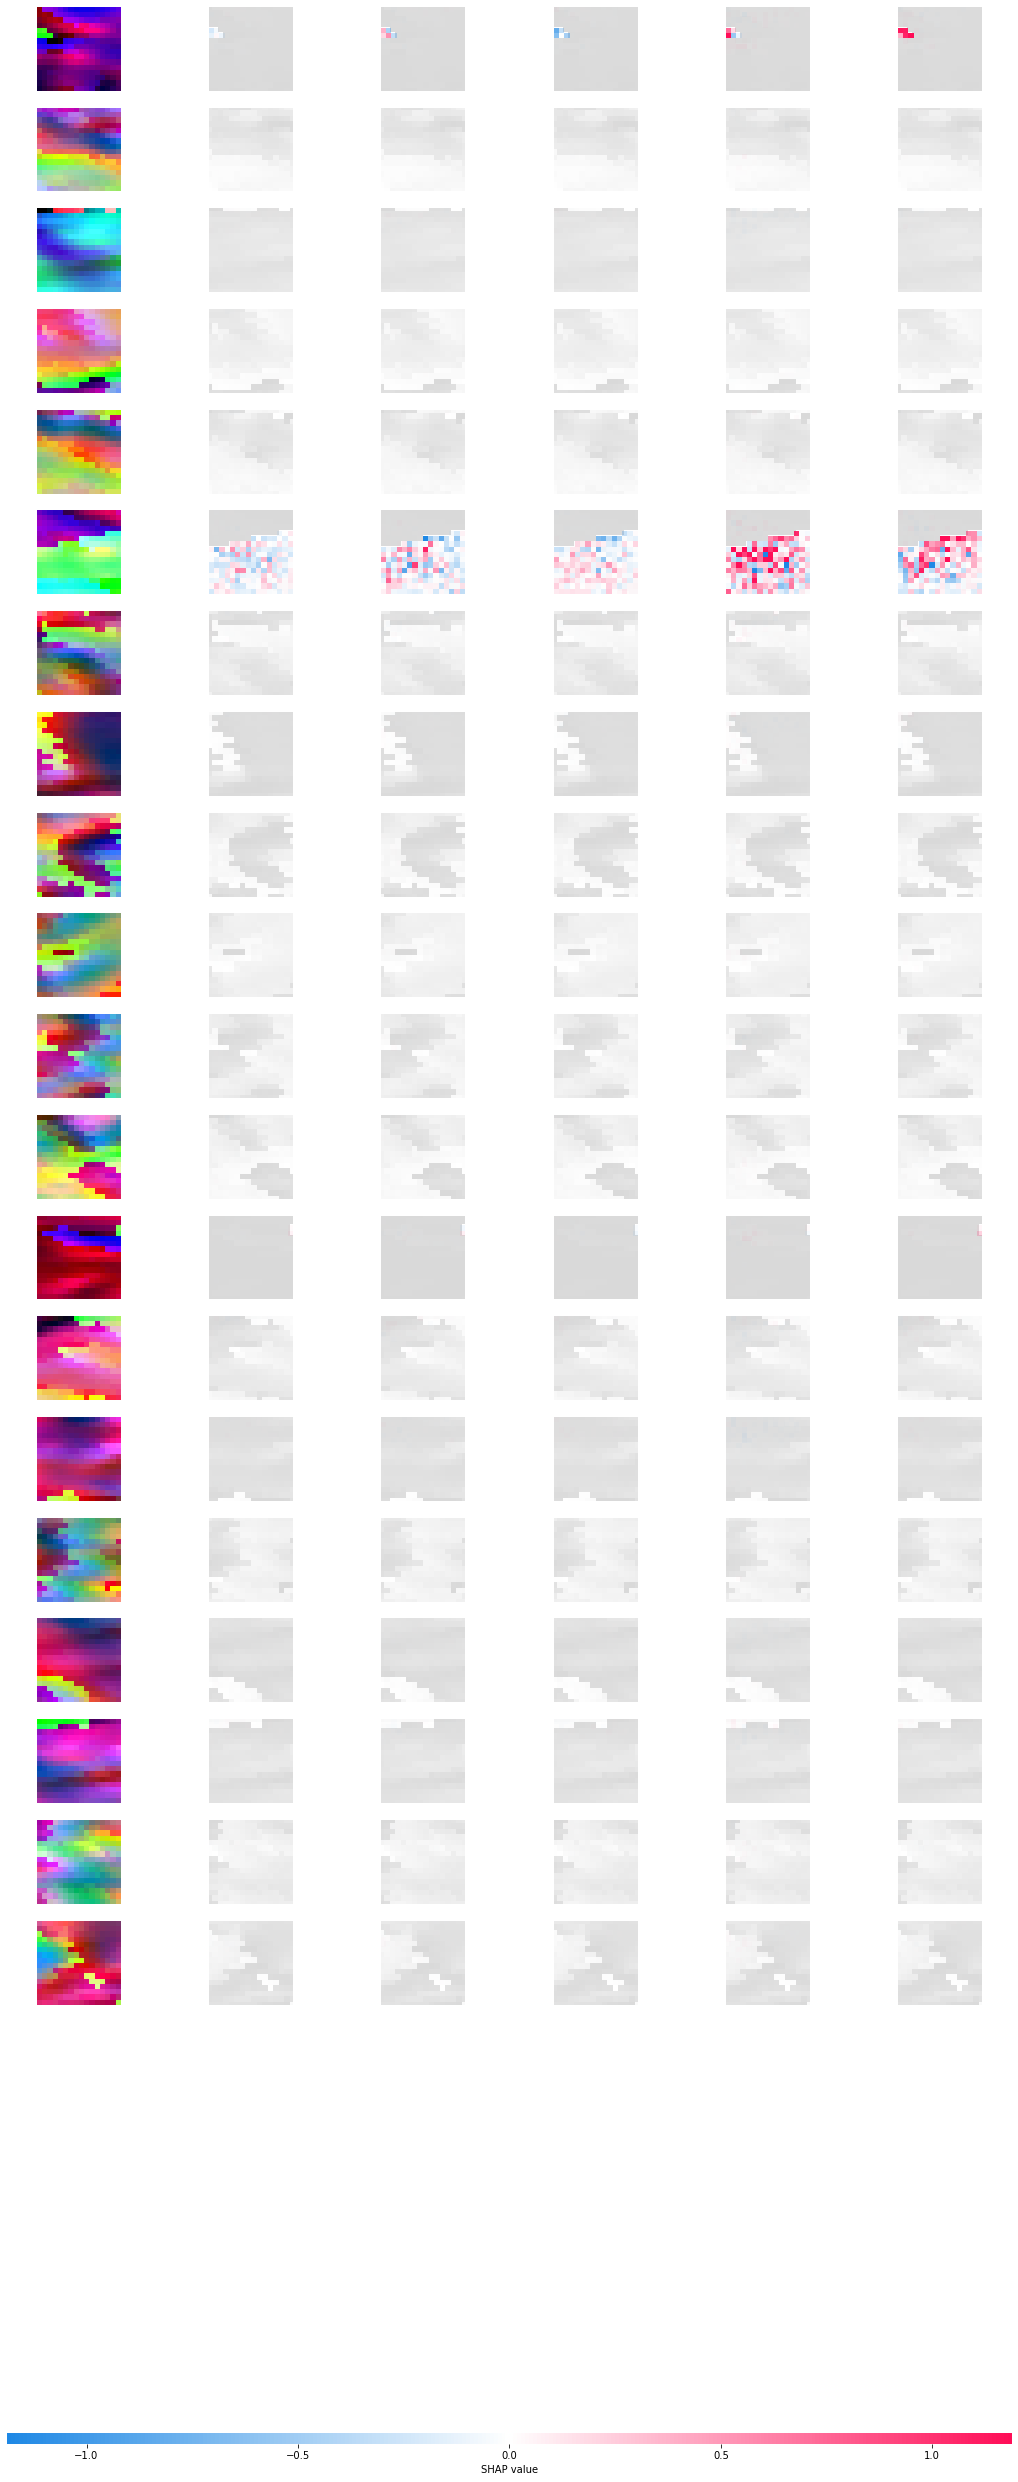

In [28]:
shap.image_plot(shap_numpy, -test_numpy)

In [29]:
shap_values = np.array(shap_values)

In [38]:
shap_values.shape

(5, 20, 6, 16, 16)

In [41]:
sum_pixels = np.sum(np.sum(abs(shap_values), -1), -1)

In [42]:
sum_pixels.shape

(5, 20, 6)

In [43]:
sum_samples = np.sum(sum_pixels, 1)

In [44]:
sum_samples.shape

(5, 6)

In [45]:
sum_samples

array([[12.27679451,  2.39195324,  0.12061125, 29.30753059,  0.9637005 ,
         0.19599835],
       [14.8804478 ,  2.84929551,  0.17483385, 41.08391798,  1.5155017 ,
         0.28283419],
       [11.29091364,  1.8872981 ,  0.11507318, 29.45378426,  1.00232739,
         0.18332597],
       [23.19327042,  4.04893182,  0.22583393, 83.01158677,  1.75711305,
         0.33871494],
       [15.18758909,  2.95378148,  0.17563721, 63.18935494,  2.28208052,
         0.38750345]])

In [50]:
sum_channel = np.sum(sum_samples,-1)
sum_channel

array([ 45.25658844,  60.78683103,  43.93272254, 112.57545093,
        84.17594669])

In [46]:
feature_names

['aspect_90M_n65w135.tif',
 'convergence_90M_n65w135.tif',
 'dev-magnitude_90M_n65w135.tif',
 'rough-scale_90M_n65w135.tif',
 'roughness_90M_n65w135.tif',
 'slope_90M_n65w135.tif']

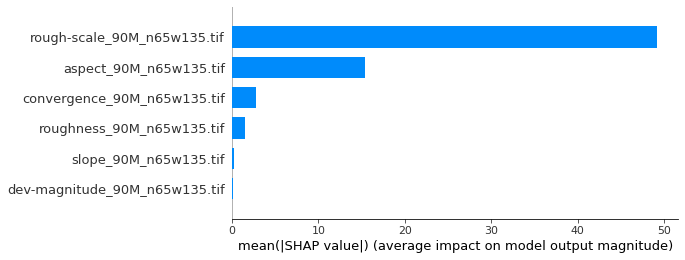

In [63]:
shap.summary_plot(sum_samples, plot_type="bar", feature_names=feature_names, show=False)

In [53]:
sum_pixels.shape

(5, 20, 6)

In [ ]:
import matplotlib.pyplot as plt

<BarContainer object of 5 artists>

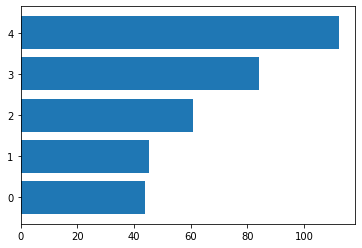

In [62]:
plt.barh(range(5), np.sort(sum_channel))

In [ ]:
plt.title